Check GPU

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
 print(f'{gpu.name}')
printm()

Gen RAM Free: 12.8 GB  | Proc size: 161.3 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB
Tesla K80


>VRAM [GB] | BATCH_SIZE [-]
>--- | ---
>8 | 8?
>12 | 48
>16 | 64?


# Get data from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/ZPO"

saves  Test.zip  val_zpo_x.zip	val_zpo_y.zip  val_zpo_z.zip


In [ ]:
!unzip -qd /content/data/ "/content/drive/My Drive/ZPO/dataset_zpo_z.zip"

In [ ]:
!unzip -qd /content/val/ "/content/drive/My Drive/ZPO/val_zpo_z.zip"

In [ ]:
!du -h /content/data
!du -h /content/val

du: cannot access '/content/data': No such file or directory
2.9G	/content/val/z_data
60M	/content/val/z_labels
3.0G	/content/val


In [ ]:
!ls /content/val

z_data	z_labels


# Setup

In [ ]:
INPUT_SIZE = 288
# Training settings
EPOCHS = 5
BATCH_SIZE = 48
CHECKPOINT_FREQ = 1


INPUT_SHAPE = (INPUT_SIZE, INPUT_SIZE)

In [ ]:
save_path = "/content/drive/My Drive/ZPO/saves/"

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Concatenate, MaxPool2D, Conv2DTranspose, Add, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, History
from tensorflow import keras
import tensorflow as tf
import numpy as np
import cv2 as cv
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
from tqdm import tqdm

# Read data

In [ ]:
train_dir = '/content/data'
val_dir = '/content/val'

In [ ]:
train_data = list(glob.glob(f'{train_dir}/*_data/*.tif'))
train_labels = list(glob.glob(f'{train_dir}/*_labels/*.tif'))

val_data = list(glob.glob(f'{val_dir}/*_data/*.tif'))
val_labels = list(glob.glob(f'{val_dir}/*_labels/*.tif'))

print(f'{len(train_data)} .tif images found in {train_dir}/.')
print(f'{len(train_labels)} .tif masks found in {train_dir}/.')

print(f'{len(val_data)} .tif images found in {val_dir}/.')
print(f'{len(val_labels)} .tif masks found in {val_dir}/.')

In [ ]:
X_train = train_data
X_val = val_data
y_train = train_labels
y_val = val_labels

0.0 1.0 (192, 256) float32


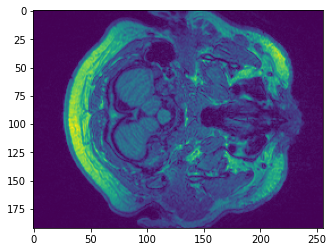

In [ ]:
temp = cv.imread(X_val[90], cv.IMREAD_ANYDEPTH)
plt.imshow(temp)
print(temp.min(), temp.max(), temp.shape, temp.dtype)

### Create data generator

In [ ]:
class DataGenerator(tf.compat.v2.keras.utils.Sequence):
 
    def __init__(self, X_data, y_data, batch_size, dim, to_fit, shuffle = True):        
        
        self.batch_size = batch_size
        self.X_data = X_data
        self.y_data = y_data
        self.to_fit = to_fit
        self.dim = dim
        self.shuffle = shuffle
        self.n = 0
        self.list_IDs = np.arange(len(self.X_data))
        self.on_epoch_end()    
    
    def __next__(self):
        # Get one batch of data
        data = self.__getitem__(self.n)
        # Batch index
        self.n += 1
        
        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end
            self.n = 0
        
        return data    
    
    def __len__(self):
        # Return the number of batches of the dataset
        return math.ceil(len(self.indexes)/self.batch_size)    
    
    
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:
            (index+1)*self.batch_size]        
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X = self._generate_x(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.X_data))
        
        if self.shuffle: 
            np.random.shuffle(self.indexes)

    def _pad_image(self, img):

        h, w = img.shape
        blank = np.zeros(INPUT_SHAPE)
        offset_h = (INPUT_SIZE - h)//2
        offset_w = (INPUT_SIZE - w)//2
        blank[offset_h:h + offset_h, offset_w:w + offset_w] = img
        return blank                
          
    def _generate_x(self, list_IDs_temp):
               
        X = np.empty((self.batch_size, *self.dim))
        
        for i, ID in enumerate(list_IDs_temp):
            
            img = cv.imread(self.X_data[ID], cv.IMREAD_ANYDEPTH)
            img = self._pad_image(img)
            X[i,] = img
                   
        return X[:,:,:, np.newaxis]

    def _generate_y(self, list_IDs_temp):
               
        y = np.empty((self.batch_size, *self.dim))
        
        for i, ID in enumerate(list_IDs_temp):
            
            img = cv.imread(self.y_data[ID], cv.IMREAD_ANYDEPTH)
            img = self._pad_image(img)
            y[i,] = img
                   
        return y[:,:,:, np.newaxis]

In [ ]:
image_generator = DataGenerator(
    X_val,
    y_val, 
    batch_size = 1, 
    dim= INPUT_SHAPE,
    shuffle= False, 
    to_fit= True
)

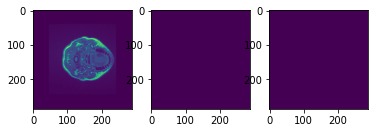

In [ ]:
fig, axes = plt.subplots(1, 3)
x, y = next(image_generator)
axes[0].imshow(x.squeeze())
axes[1].imshow(y.squeeze())
cut = np.zeros_like(x.squeeze())
cut[y.squeeze() == 1] = x.squeeze()[y.squeeze() == 1]
axes[2].imshow(cut)

# Create models

In [ ]:
def create_block(input_: keras.layers.Layer, filters: int, kernel: int, strides: int, dialation_rate: int):
    x = input_
    x = Conv2D(filters, kernel, strides= strides, padding= 'same', dilation_rate= dialation_rate)(x)
    x = BatchNormalization()(x)
    # x = Activation(activation)(x)
    x = tf.nn.leaky_relu(x, alpha= 0.01)
    return x

## Model


In [ ]:
def get_generator():
    model = None
    
    input_ = Input((INPUT_SIZE, INPUT_SIZE, 1))
    
    print(input_.shape)
    # Encoder
    block1 = create_block(input_, 64, 5, 2, 1)
    block2 = create_block(block1, 128, 3, 2, 1)
    block3 = create_block(block2, 256, 3, 2, 1)
    
    # Bottleneck
    x = create_block(block3, 256, 3, 1, 1)
    x = create_block(x, 256, 3, 1, 2)
    x = create_block(x, 256, 3, 1, 4)
    x = create_block(x, 256, 3, 1, 8)
    x = create_block(x, 256, 3, 1, 16)

    # x = create_block(x, 256, 3, 2, 1)

    x = Concatenate()([block3, x])
    x = Conv2DTranspose(256, 3, strides= 2, padding= 'same', dilation_rate= 1)(x)
    x = BatchNormalization()(x)
    x = tf.nn.leaky_relu(x, alpha= 0.01)                  

    # Decoder
    x = Concatenate()([block2, x])
    x = Conv2DTranspose(128, 3, strides= 2, padding='same')(x)
    # x = Activation('relu')(x)
    x = tf.nn.leaky_relu(x, alpha= 0.01)
    
    
    x = Concatenate()([block1, x])
    x = Conv2DTranspose(64, 3, strides= 2, padding='same')(x)
    # x = Activation('relu')(x)
    x = tf.nn.leaky_relu(x, alpha= 0.01)
    
    
    x = Conv2DTranspose(1, 1, strides= 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    

    
    return Model(input_, x)
    

In [ ]:
model = get_generator()
model.summary()

(None, 288, 288, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 288, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 144, 144, 64) 1664        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 144, 144, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu (TensorFl [(None, 144, 144, 64 0           batch_normalization[0][0]        
__________________________________________________________________________

# Train

## Losses

In [ ]:
BCE = keras.losses.BinaryCrossentropy(reduction='none')

In [ ]:
def discriminator_loss(mask, output):
  # mask = mask.reshape(output.shape)
  ls = BCE(mask, output)
  return ls

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Run training

In [ ]:
model.compile(
    optimizer= discriminator_optimizer,
    loss= discriminator_loss,
    metrics=['accuracy', 'mse']
                      )

In [ ]:
train_generator = DataGenerator(
    X_train,
    y_train, 
    batch_size = BATCH_SIZE, 
    dim= INPUT_SHAPE,
    shuffle= True, 
    to_fit= True
)

val_generator = DataGenerator(
    X_val,
    y_val, 
    batch_size = BATCH_SIZE, 
    dim= INPUT_SHAPE,
    shuffle= False, 
    to_fit= True
)


In [ ]:
model_history = model.fit(
    train_generator,
     batch_size=BATCH_SIZE,
      epochs=EPOCHS,
       validation_data=val_generator, 
       validation_batch_size=BATCH_SIZE
       )

Epoch 1/5
1708/1708 [==============================] - 4918s 3s/step - loss: 0.0386 - accuracy: 0.9893 - mse: 0.0100 - val_loss: 0.0127 - val_accuracy: 0.9960 - val_mse: 0.0031
Epoch 2/5
1708/1708 [==============================] - 4907s 3s/step - loss: 0.0234 - accuracy: 0.9925 - mse: 0.0061 - val_loss: 0.0157 - val_accuracy: 0.9944 - val_mse: 0.0043
Epoch 3/5
1708/1708 [==============================] - 4931s 3s/step - loss: 0.0174 - accuracy: 0.9940 - mse: 0.0047 - val_loss: 0.0111 - val_accuracy: 0.9959 - val_mse: 0.0031
Epoch 4/5
1708/1708 [==============================] - 4958s 3s/step - loss: 0.0133 - accuracy: 0.9953 - mse: 0.0036 - val_loss: 0.0096 - val_accuracy: 0.9965 - val_mse: 0.0026
Epoch 5/5
1708/1708 [==============================] - 4940s 3s/step - loss: 0.0109 - accuracy: 0.9961 - mse: 0.0030 - val_loss: 0.0133 - val_accuracy: 0.9952 - val_mse: 0.0037


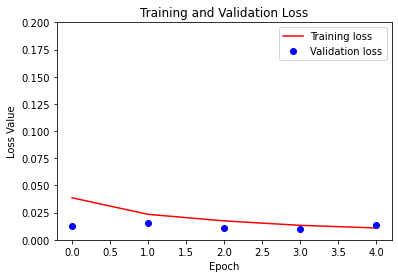

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.2])
plt.legend()
plt.show()


# Results

In [ ]:
image_generator = DataGenerator(
        X_val,
        y_val,
        batch_size = 1, 
        dim= INPUT_SHAPE,
        shuffle= False,
        to_fit= True
    )

Text(0.5, 1.0, 'label')

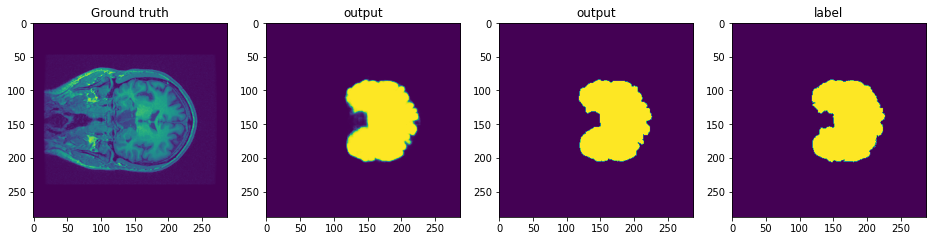

In [ ]:
gt, y = next(image_generator)
figure, axes = plt.subplots(1, 4, figsize=[16,16])
axes[0].imshow(gt.squeeze())
axes[0].set_title('Ground truth')

output = model(gt)
axes[1].imshow(output.numpy().squeeze())
axes[1].set_title('output')

ret, thresh = cv.threshold(output.numpy().squeeze(), 0.5, 1.0, cv.THRESH_BINARY)
axes[2].imshow(thresh)
axes[2].set_title('output')

axes[3].imshow(y.squeeze())
axes[3].set_title('label')

In [ ]:
model.save(f'{save_path}/model_g_z')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/ZPO/saves//model_g_y/assets


In [ ]:
model = tf.keras.models.load_model(f'{save_path}/model_g_z', compile= False)

In [ ]:
model.compile(
    optimizer= discriminator_optimizer,
    loss= discriminator_loss,
    metrics=['accuracy', 'mse']
                      )


Text(0.5, 1.0, 'diff')

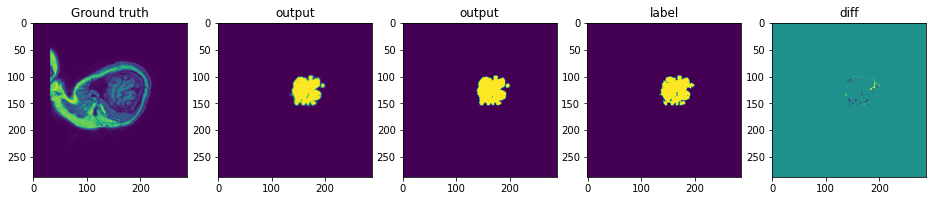

In [ ]:
gt, y = next(image_generator)
figure, axes = plt.subplots(1, 5, figsize=[16,16])
axes[0].imshow(gt.squeeze())
axes[0].set_title('Ground truth')

output = model(gt)
axes[1].imshow(output.numpy().squeeze())
axes[1].set_title('output')

ret, thresh = cv.threshold(output.numpy().squeeze(), 0.5, 1.0, cv.THRESH_BINARY)
axes[2].imshow(thresh)
axes[2].set_title('output')

axes[3].imshow(y.squeeze())
axes[3].set_title('label')

axes[4].imshow(y.squeeze() - thresh)
axes[4].set_title('diff')

# Test

In [ ]:
!unzip -qd /content/test/ "/content/drive/My Drive/ZPO/Test.zip"

In [ ]:
import numpy as np
import nibabel as nib

from typing import Tuple, List
from pathlib import Path

In [ ]:
def load_raw_volume(path: Path) -> Tuple[np.ndarray, np.ndarray]:
  data: nib.Nifti1Image = nib.load(str(path))
  data = nib.as_closest_canonical(data)
  raw_data = data.get_fdata(caching='unchanged', dtype=np.float32)
  return raw_data, data.affine


def load_labels_volume(path: Path) -> np.ndarray:
  return load_raw_volume(path)[0].astype(np.uint8)


def save_labels(data: np.ndarray, affine: np.ndarray, path: Path):
  nib.save(nib.Nifti1Image(data, affine), str(path))


def show_slices(slices: List[np.ndarray]):
   fig, axes = plt.subplots(1, len(slices))
   for i, data_slice in enumerate(slices):
       axes[i].imshow(data_slice.T, cmap="gray", origin="lower")

############################

def _pad_image(img):
    h, w = img.shape
    blank = np.zeros(INPUT_SHAPE)
    offset_h = (INPUT_SIZE - h)//2
    offset_w = (INPUT_SIZE - w)//2
    blank[offset_h:h + offset_h, offset_w:w + offset_w] = img
    return blank, offset_h, h + offset_h, offset_w, w + offset_w      

def preprocess_input(img):
    if img.max() - img.min() != 0:
        img = np.float32((img - img.min()) / (img.max() - img.min()))
    if img.max() <= 1.0 and img.min() >= 0.0:
        return img

    else:
       return None


In [ ]:
!rm -r Predictions

In [ ]:
predictions_base_path = Path('/content/Predictions')
first_dataset_predictions_path = predictions_base_path / 'first'
second_dataset_predictions_path = predictions_base_path / 'second'

first_dataset_predictions_path.mkdir(exist_ok=True, parents=True)
second_dataset_predictions_path.mkdir(exist_ok=True, parents=True)

In [ ]:
first_dataset_test_path = Path('/content/test/Test/test')
second_dataset_test_path = Path('/content/test/Test/test_2')

for scan_path in first_dataset_test_path.iterdir():
  data, affine = load_raw_volume(scan_path)
  labels = np.zeros(data.shape, dtype=np.uint8)
  
  # Przykład dla osi 'z':
  x_size, y_size, z_size = data.shape
  for z_index in range(z_size):
    data_slice = data[:, :, z_index]
    preprocessed_data_slice = preprocess_input(data_slice)
    padded, h1, h2, w1, w2 = _pad_image(preprocessed_data_slice)
    output = model(padded.reshape(1,INPUT_SIZE, INPUT_SIZE, 1))
    ret, prediction = cv.threshold(output.numpy().squeeze(), 0.5, 1.0, cv.THRESH_BINARY)
    labels[:, :, z_index] = prediction[h1:h2, w1:w2]
  
  save_labels(labels, affine, first_dataset_predictions_path / scan_path.name)

for scan_path in second_dataset_test_path.iterdir():
  data, affine = load_raw_volume(scan_path / 'T1w.nii.gz')
  labels = np.zeros(data.shape, dtype=np.uint8)

  # Tutaj należy przeiterować się na przykład po jednej z osi, wykonać predykcję dla każdego przekroju i wpisać do macierzy labels
  # UWAGA - maska powinna zawierać jedynie wartości 0 i 1
  # UWAGA - predykcje są liczbami zmiennoprzecinkowymi z zakresu 0 do 1 - należy je zbinaryzować wybierając jakiś próg (na przykład 0.5)

  # Przykład dla osi 'z':
  x_size, y_size, z_size = data.shape
  for z_index in range(z_size):
    data_slice = data[:, :, z_index]
    preprocessed_data_slice = preprocess_input(data_slice)
    padded, h1, h2, w1, w2 = _pad_image(preprocessed_data_slice)
    output = model(padded.reshape(1,INPUT_SIZE, INPUT_SIZE, 1))
    ret, prediction = cv.threshold(output.numpy().squeeze(), 0.5, 1.0, cv.THRESH_BINARY)
    labels[:, :, z_index] = prediction[h1:h2, w1:w2]
  
  save_labels(labels, affine, second_dataset_predictions_path / f'{scan_path.name}.nii.gz')

In [ ]:
import requests
import zlib

dice = []
auc = []

for dataset_predictions_path in (first_dataset_predictions_path, second_dataset_predictions_path):
  for prediction_path in dataset_predictions_path.iterdir():
    prediction_name = prediction_path.name[:-7]  # Usuwanie '.nii.gz' z nazwy pliku
    prediction = nib.load(str(prediction_path))

    response = requests.post(f'http://vision.dpieczynski.pl:8080/{prediction_name}', data=zlib.compress(prediction.to_bytes()))

    
    if response.status_code == 200:
        print(dataset_predictions_path.name, prediction_path.name, response.json())
        dice.append(response.json()['dice'])
        auc.append(response.json()['auc']) 
    else:
        print(f'Error processing prediction {dataset_predictions_path.name}/{prediction_name}: {response.text}')

first d0858c4acdecad0b89bae8e1c55ee92c.nii.gz {'dice': 0.9868137740143629, 'auc': 0.9944658008837487}
first 64051b3483da339bf5792b5820faf6ae.nii.gz {'dice': 0.9796847915398991, 'auc': 0.9895577634663493}
first 780913c65053b3d29a96856ecc02b654.nii.gz {'dice': 0.9813215552573118, 'auc': 0.9938169717690045}
first 9e0d0d0f40e55e63cf8d218f559b162c.nii.gz {'dice': 0.9333227364173551, 'auc': 0.9864451965391942}
first ae4c2fcb653e5b3ce978c783121722c8.nii.gz {'dice': 0.9839281862595519, 'auc': 0.9939614582106948}
first 6bad4c29bf8709bfeb96be167d34b30f.nii.gz {'dice': 0.981886635234246, 'auc': 0.9914806523810843}
first 82922aea8b29f4daae228061912634f4.nii.gz {'dice': 0.9862199565565135, 'auc': 0.9949869080456657}
first 1c3064790751e45d903399e9998af51b.nii.gz {'dice': 0.9849514146309553, 'auc': 0.9908001585638173}
first c5226d116bf06fcda3bba8baf9e9229f.nii.gz {'dice': 0.9843777825266232, 'auc': 0.991911021365539}
first 9be1a6385279fcdfb613d0cdf73c00a7.nii.gz {'dice': 0.9765831777164306, 'auc': 0.

In [ ]:
dice = np.array(dice)
auc = np.array(auc)

In [ ]:
print(f'avg dice: {np.average(dice)}')
print(f'avg auc: {np.average(auc)}')
print(f'min dice: {dice.min()}')
print(f'min auc: {auc.min()}')

avg dice: 0.9832369237032956
avg auc: 0.9922444484457421
min dice: 0.9333227364173551
min auc: 0.9829489788363273


In [ ]:
pred = list(glob.glob(f'/content/Predictions/*/*'))
test = list(glob.glob(f'/content/test/Test/*/*'))

In [ ]:
print(len(pred), len(test))

97 97


In [ ]:
!zip -rq predictions.zip /content/Predictions/

In [ ]:
!cp /content/predictions.zip "/content/drive/My Drive/ZPO/saves/predictions.zip"